In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import phate
import scprep
import scipy


import sys
import yaml
import phate
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from sklearn.manifold import MDS


sys.path.append("../")
from src.models.lit_encoder import LitAutoencoder
from src.models.lit_encoder import LitDistEncoder
from src.data.make_dataset import train_dataloader
from src.data.make_dataset import make_n_sphere_two
from src.data.make_dataset import make_tree
from src.data.make_dataset import make_live_seq
from src.data.make_dataset import make_pbmc
from src.data.make_dataset import make_ipsc
from src.data.make_dataset import make_swiss
from src.fim_noemb import FIM
import os
from sklearn.decomposition import PCA
import math
import random
import pickle

import h5py
import numpy as np
import scipy.io as sio
import pandas as pd
import sklearn
from sklearn.manifold import Isomap
from sklearn import datasets

#from mpl_tookits import mplot3d


# Define JSD Function

In [2]:
#"""

def computeJSD(X):
    
    #NOTE: Input for this function is matrix where the rows are log-transformed probabilites

    jsd = torch.zeros((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):

        p = X[i,:]
        q = X
        m = (0.5 * (p.exp() + q.exp()))
        

        kone = 0.5 *( (p.exp() * (p - m.log() ) ).sum(dim=1))
        ktwo = 0.5 *( (q.exp() * (q - m.log() ) ).sum(dim=1))
        k = kone + ktwo

        jsd[i,:] = k
     
    jsd.fill_diagonal_(0) #setting diagonal to 0 to avoid nan's
            
    return jsd.to('cuda')
    
"""

def computeJSD(X):
    
    #NOTE: Input for this function is matrix where rows are probabilites

    jsd = torch.zeros((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):

        p = X[i,:]
        q = X
        m = (0.5 * (p + q))
        

        kone = 0.5 *( (p * (p.log() - m.log() ) ).sum(dim=1))
        ktwo = 0.5 *( (q * (q.log() - m.log() ) ).sum(dim=1))
        k = kone + ktwo

        jsd[i,:] = k
     
    jsd.fill_diagonal_(0) #setting diagonal to 0 to avoid nan's
            
    return jsd.to('cuda')

"""

"\n\ndef computeJSD(X):\n    \n    #NOTE: Input for this function is matrix where rows are probabilites\n\n    jsd = torch.zeros((X.shape[0],X.shape[0]))\n    for i in range(X.shape[0]):\n\n        p = X[i,:]\n        q = X\n        m = (0.5 * (p + q))\n        \n\n        kone = 0.5 *( (p * (p.log() - m.log() ) ).sum(dim=1))\n        ktwo = 0.5 *( (q * (q.log() - m.log() ) ).sum(dim=1))\n        k = kone + ktwo\n\n        jsd[i,:] = k\n     \n    jsd.fill_diagonal_(0) #setting diagonal to 0 to avoid nan's\n            \n    return jsd.to('cuda')\n\n"

# Tree Data

In [8]:
# Data Parameters
dataset = "tree"
n_obs = 1500
n_dim = 10
batch_size = 150

# Model param
encoder_layer = [100,100,50]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 20  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 5 # PHATE kernel number of Nearest Neighbors.
logp=False #Rescale of PHATE parameters

# Trainer param
max_epochs = 150
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "tree_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [9]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="tree_autoenocder_logp", name=exp_name) if wandb else False

In [10]:
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)


In [12]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
# train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

# Defining the pytorch lightning model.
model = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model, train_dataloaders=train_loader)

Global seed set to 390


[Linear(in_features=10, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 16.2 K
1 | decoder | Sequential | 242   
---------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [13]:
#save model (and load model)

torch.save(model.state_dict(),'saved_models/tree_model_5_22.pt')
#model.load_state_dict(torch.load('saved_models/tree_model_1_25_JSD.pt'))



# Showing regular PHATE with 5 and 8 branches

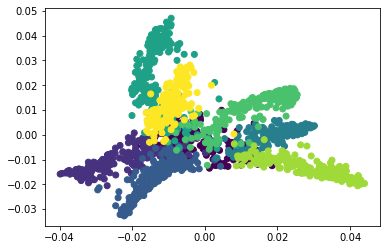

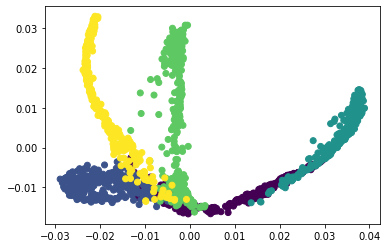

In [47]:
#Load tree data and plot PHATE embedding
tree_data, tree_clusters = phate.tree.gen_dla(n_dim=10, n_branch=8, branch_length=200)
tree_phate = phate.PHATE(random_state=42, verbose=False, knn=5).fit_transform(tree_data)

#200 branches
plt.figure()
plt.scatter(tree_phate[:,0],tree_phate[:,1],c=tree_clusters)
tree_data, tree_clusters = phate.tree.gen_dla(n_dim=10, n_branch=5, branch_length=300)
tree_phate = phate.PHATE(random_state=42, verbose=False, knn=5).fit_transform(tree_data)

#300 branches
plt.figure() 
plt.scatter(tree_phate[:,0],tree_phate[:,1],c=tree_clusters)

# Comparison of regular PHATE with JSD phate

Text(0, 0.5, 'PHATE Axis 2')

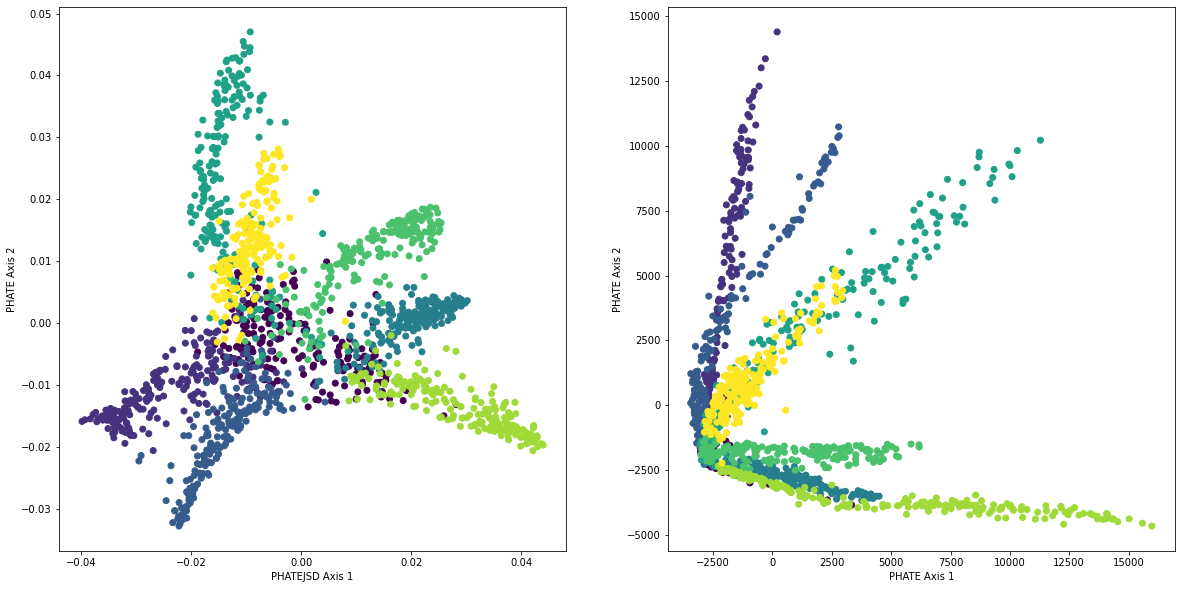

In [18]:
#Load tree data and get PHATE operator
tree_data, tree_clusters = phate.tree.gen_dla(n_dim=10, n_branch=8, branch_length=200)
tree_phate = phate.PHATE(random_state=42, verbose=False, knn=5).fit_transform(tree_data)#.detach().cpu().numpy())
phate_op = phate.PHATE(random_state=42, verbose=False, knn=5).fit(tree_data)#.detach().cpu().numpy())

#NOTE: JSD Visualization is better with DIFFUSION POTENTIAL
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()
gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_tree= mds_operator.fit_transform(gtdist.detach().cpu().numpy())

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.scatter(tree_phate[:,0],tree_phate[:,1],c = tree_clusters)
plt.xlabel("PHATEJSD Axis 1")
plt.ylabel("PHATE Axis 2")
plt.subplot(122)
plt.scatter(phateJSDemb_tree[:,0],phateJSDemb_tree[:,1],c = tree_clusters)
plt.title("")
plt.xlabel("PHATE Axis 1")
plt.ylabel("PHATE Axis 2")

# GET predictions

In [14]:

tree_data, tree_phate, tree_clusters = make_tree(n_obs=150, dim=10,emb_dim=2,knn=knn)
model.cuda()
model.eval()
tree_data.cuda()
tree_data = tree_data.to('cuda')
pred = model.encode(tree_data).detach().cpu().numpy()


# Compute FIM 

In [15]:

n_obs = tree_data.shape[0]
model.cuda()
fcn = model.encode
#print(type(tree_data))
#tree_data.cuda()
print(n_dim)
print(emb_dim)
print(pred.shape)
fisher = FIM(tree_data,fcn,n_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()
e,v = fisher.get_eigs()

#quad = fisher.get_quadform(e[0,:])
#eone = np.zeros((v.shape[2])) #dimensionality of eigenvectors
#eone[0] = 1
#quad = fisher.get_quadform(eone)
volume = fisher.get_volume()

#Projecting eigenvectors to two dimensions for visualization
tvec = torch.unsqueeze(torch.tensor(v[:,:,0]).float().cuda(),0)
model.eval()
vout = model.encode(tvec).squeeze()
#neivec = mds_operator.fit_transform(vout.detach().cpu().numpy())


10
50
(1600, 50)


In [16]:
pcaeivec = vout.squeeze().detach().cpu().numpy()

In [ ]:
print(pcaeivec.shape)

# Color by Volume and Trace/extract eigenvalues

Mean Trace 0.04212279538838252
Max Trace 0.1363779101539359


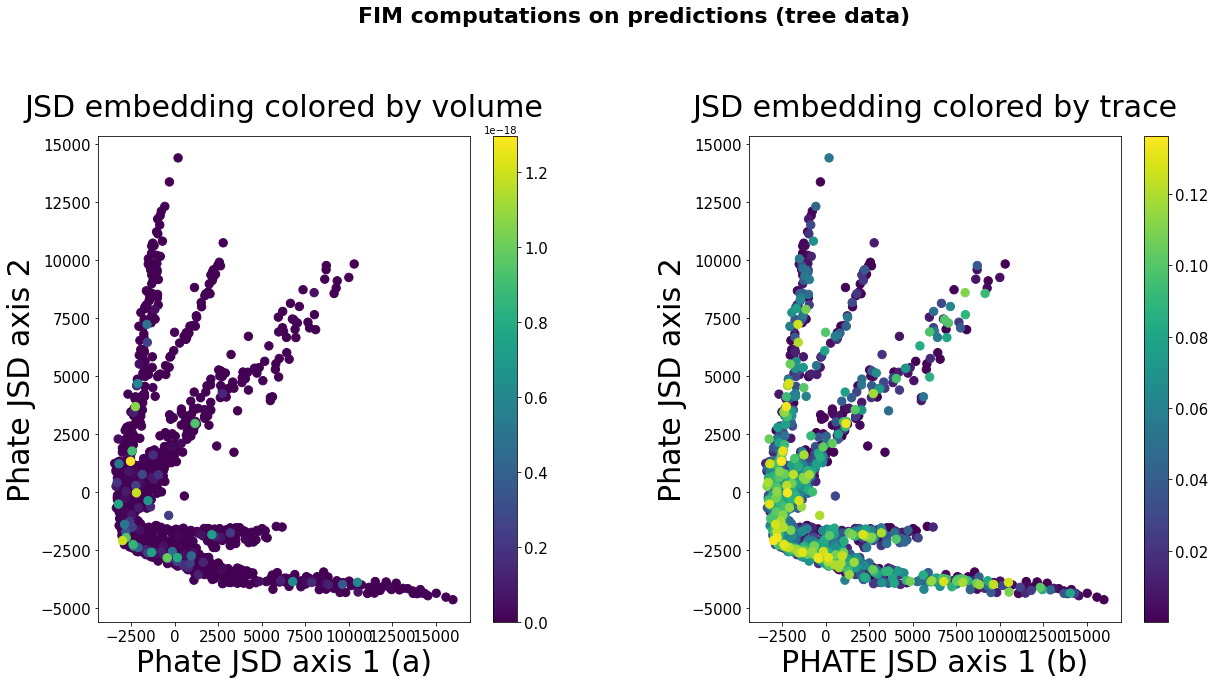

In [26]:

#Pads axis titles
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 


#Function for discarding outliers
per = 0.95 #CI to keep
def discard_out(metric,n_obs,per):
    
    ns_obs = per*n_obs
    out = int((n_obs - ns_obs)/2)
    sor = np.argsort(metric)
    lwindx = out
    upindx = n_obs - out
    sortind = sor[lwindx:upindx]
    return sortind


#Get Volume
#volume = volume/np.max(volume) #normalization
vind = discard_out(volume,n_obs,per)
nvolume = volume[vind]#/np.max(volume[vind])


#Compute quadratic form of first eigenvector
#quad = quad/np.max(quad)
#qind = discard_out(quad,n_obs,per)
#nquad = quad[qind]/np.max(quad[qind])


#Get Max eigenvalue
#emax = e[:,0]/np.max(trace) #normalized trace
#eind = discard_out(emax,n_obs,per)
#ne = emax[eind]/np.max(emax[eind])


#Get Trace
trace = np.zeros((n_obs))
for i in range(n_obs):
    trace[i] = np.sum(e[i,:])

#trace = trace/np.max(trace) #normalized trace
tind = discard_out(trace,n_obs,per)
ntrace = trace[tind]#/np.max(trace[tind])


fig = plt.figure(figsize=(20,10))
plt.suptitle("FIM computations on predictions (tree data) ",fontsize=22,fontweight='bold')
plt.subplots_adjust(hspace=1.0,wspace=0.4,top=0.8)

#Trace
#plt.subplot(221)
#plt.title("Trace of FIM",fontsize=16)
#plt.plot(nvolume,linewidth=3)
#plt.xlabel("Data points",fontsize=16)
#plt.ylabel("Magnitude",fontsize=16)

#Volume
plt.subplot(121)
plt.title("JSD embedding colored by volume",fontsize=30)
#plt.scatter(predemb[vind, 0], predemb[vind, 1], c= nvolume)
plt.scatter(phateJSDemb_tree[tind, 0], phateJSDemb_tree[tind, 1], c= nvolume,s=70)
plt.xlabel("Phate JSD axis 1 (a)",fontsize=30)
plt.ylabel("Phate JSD axis 2",fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15) 


#Eigenspectrum
#rint = np.random.randint(0,n_obs,size=10)
#plt.subplot(132)
#plt.title("FIM eigenspectrum" ,fontsize=20)
#for i in rint:
#    plt.plot(e[i,:],linewidth=3)
    #plt.plot(e[eind[i],:]/np.max(e[eind[i],:]))
#plt.xlabel("Eigenvalues (b)",fontsize=24)
#plt.ylabel("Magnitdue",fontsize=24)
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)

#Trace
#plt.subplot(223)
#plt.title("Encoded embedding colored by trace of FIM",fontsize=16)
#plt.scatter(predemb[tind, 0], predemb[tind, 1], c= ntrace)
#plt.xlabel("PHATE axis 1",fontsize=16)
#plt.ylabel("PHATE axis 2",fontsize=16)
#plt.colorbar()



#Trace
plt.subplot(122)
plt.title("JSD embedding colored by trace",fontsize=30)
#plt.scatter(predemb[tind, 0], predemb[tind, 1], c= ntrace)
plt.scatter(phateJSDemb_tree[tind, 0], phateJSDemb_tree[tind, 1], c= ntrace,s=70)
plt.xlabel("PHATE JSD axis 1 (b)",fontsize=30)
plt.ylabel("Phate JSD axis 2",fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15) 



#Visualization of eignevectors
#reint = np.random.randint(0,tree_phate.shape[0],size=500) #Random 
#plt.subplot(224)
#plt.title("Top eigenvector of FIMs on embedding",fontsize=16)
#plt.scatter(predemb[reint,0],predemb[reint,1],c=tree_clusters[reint])
#plt.quiver(predemb[reint,0],predemb[reint,1],neivec[reint,0],neivec[reint,1],color = 'black',scale=20)
#plt.xlabel("embedding axis 1",fontsize=16)
#plt.ylabel("embedding axis 2",fontsize=16)

plt.savefig("Figures/8_200_tree_FIMcomps_3_17_JSD_MDS_100_70_20.png")
np.save("saved_data/8_200_tree_3_17_1500_ground_truth_JSD_100_70_20.npy",phateJSDemb_tree)
np.save("saved_data/8_200_tree_3_17_ind_100_70_20.npy",tind)
np.save("saved_data/8_200_tree_3_17_1500_trace_100_70_20.npy",ntrace)
np.save("saved_data/8_200_tree_3_17_1500_volume_100_70_20.npy",nvolume)


print("Mean Trace",np.mean(ntrace))
print("Max Trace",np.max(ntrace))



[1.32605418e-05 1.43768479e-05 1.49232421e-05 ... 2.52709721e-01
 2.52990694e-01 2.53971841e-01]
[1.11821946e-05 1.15133602e-05 1.28512123e-05 ... 1.36733285e-01
 1.37162614e-01 1.40099870e-01]
[2.06250985e-05 2.11757533e-05 2.18826158e-05 ... 1.29140077e-01
 1.30194106e-01 1.30632415e-01]

Correlation between 50 and 30 [[1.         0.98362658]
 [0.98362658 1.        ]]

Correlation between 50 and 20 [[1.         0.99138835]
 [0.99138835 1.        ]]

Correlation between 30 and 20 [[1.         0.99840474]
 [0.99840474 1.        ]]


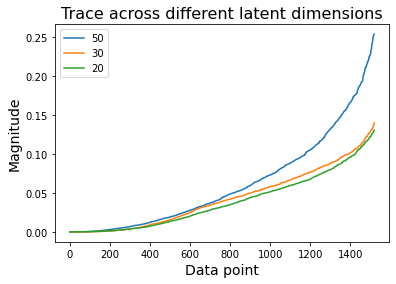

In [15]:
# Get trace



trace_one = np.load("saved_data/8_200_tree_3_17_1500_trace.npy")
trace_two = np.load("saved_data/8_200_tree_3_17_1500_trace_100_80_30.npy")
trace_three = np.load("saved_data/8_200_tree_3_17_1500_trace_100_70_20.npy")

print(trace_one)
print(trace_two)
print(trace_three)



print("")
print("Correlation between 50 and 30",np.corrcoef(trace_one,trace_two))
print("")
print("Correlation between 50 and 20",np.corrcoef(trace_one,trace_three))
print("")
print("Correlation between 30 and 20",np.corrcoef(trace_two,trace_three))

plt.figure()
plt.title("Trace across different latent dimensions",fontsize=16)
plt.xlabel("Data point",fontsize=14)
plt.ylabel("Magnitude",fontsize=14)
plt.plot(trace_one)
plt.plot(trace_two)
plt.plot(trace_three)
plt.legend(["50","30","20"])



# Visualization of FIM matrices

In [ ]:
plt.figure(figsize = (24,10))
plt.suptitle("Visualization of FIM's for 10 random samples (tree data)",fontsize=18,fontweight='bold')
for i in range(len(rint)):
    plt.subplot(2,5,i+1)
    plt.imshow(fishermat[rint[i],:,:])
    plt.colorbar()
    
plt.savefig('random_FIMs.png')

In [ ]:
#Compute and sort embedding distances
distind = np.argsort(np.linalg.norm((predemb - predemb.mean(0)),axis=1))
plt.figure(figsize = (10,10))
plt.suptitle("Visualization of FIM's by region (tree data)",fontsize=18,fontweight='bold')

a = int(len(distind)) -1 #specifies index in sorted vector to get edges

for i in range(6):
    plt.subplot(3,2,i+1)
    
    if i == 1 or i == 3 or i == 5: #(for plotting)
        if i == 1:
            plt.title("Center",fontsize=18)
        plt.imshow(fishermat[distind[i],:,:])
        plt.colorbar()
        
    else:
        if i == 0: #(for plotting)
            plt.title("Edge",fontsize=18)
        plt.imshow(fishermat[distind[a],:,:])
        plt.colorbar()
        
    a = a - 1
    
plt.savefig("Figures/5_300_tree_regional_FIMs_1_17.png")

plt.figure()
plt.scatter(predemb[:,0],predemb[:,1])
plt.scatter(predemb[distind[:10],0],predemb[distind[:10],1],c='red')

# Sphere Data

In [ ]:
# Data Parameters
dataset = "sphere"
n_obs = 1500
n_dim = 10
batch_size = 100

# Model param
encoder_layer = [100,100,50]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 10 # PHATE kernel number of Nearest Neighbors.
logp=True

# Trainer param
max_epochs = 100
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "sphere_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [ ]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="sphere_autoenocder_logp", name=exp_name) if wandb else False

In [ ]:
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

In [ ]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
#train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

# Defining the pytorch lightning model.
model_sphere = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model_sphere, train_dataloaders=train_loader)

In [ ]:
#save model (and load model)

torch.save(model_sphere.state_dict(),'saved_models/sphere_model_1_22.pt')
#model.load_state_dict(torch.load('saved_models/sphere_model_1_18.pt'))

In [ ]:
#Evaluate pytorch model on new data

sphere_data, sphere_phate = make_n_sphere_two(n_obs=n_obs,dim=10,emb_dim=2,knn=knn)
sphere_data = sphere_data.to('cuda')
model_sphere.cuda()
model_sphere.eval()
pred = model_sphere.encode(sphere_data).detach().cpu().numpy()

mds_operator = MDS()
predemb = mds_operator.fit_transform(pred)


In [ ]:
phate_op = phate.PHATE(random_state=42, verbose=False, n_components=emb_dim, knn=10).fit(sphere_data.detach().cpu().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()

mds_operator = MDS()
sphereJSDemb = mds_operator.fit_transform(diff_pot)

In [ ]:


plt.figure()
plt.title("Embedding predictions")
plt.scatter(pred[:, 0], pred[:, 1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure(figsize = (14,6))
plt.suptitle("Ground Truth and MDS Embedding",fontweight='bold',fontsize=18)
plt.subplot(121)
plt.title("MDS emebedding of predictions",fontsize=16)
plt.scatter(predemb[:, 0], predemb[:, 1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)

plt.subplot(122)
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(sphereJSDemb[:,0],sphereJSDemb[:,1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)


np.save("saved_data/1500_sphere_1_22_1500_pred.npy",pred)
np.save("saved_data/1500_sphere_1_22_1500_pred_MDS.npy",predemb)
np.save("saved_data/1500_sphere_1_22_1500_ground_truth.npy",sphereJSDemb)
plt.savefig("Figures/1500_sphere_1_22_1500_ground_truth.png")

In [ ]:
print(sphere_data.shape)

In [ ]:

#Compute FIM 
n_obs = sphere_data.shape[0]
model_sphere.cuda()
fcn = model_sphere.encode
fisher = FIM(sphere_data,fcn,n_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()
e,v = fisher.get_eigs()

#quad = fisher.get_quadform(e[0,:])
#eone = np.zeros((v.shape[2])) #dimensionality of eigenvectors
#eone[0] = 1
#quad = fisher.get_quadform(eone)
volume = fisher.get_volume()

#Projecting eigenvectors to two dimensions for visualization
tvec = torch.unsqueeze(torch.tensor(v[:,:,0]).float().cuda(),0)
model_sphere.eval()
vout = model_sphere.encode(tvec).squeeze()
neivec = mds_operator.fit_transform(vout.detach().cpu().numpy())




In [ ]:
#Function for discarding outliers
per = 0.95 #CI to keep
def discard_out(metric,n_obs,per):
    
    ns_obs = per*n_obs
    out = int((n_obs - ns_obs)/2)
    sor = np.argsort(metric)
    lwindx = out
    upindx = n_obs - out
    sortind = sor[lwindx:upindx]
    return sortind


#Get Volume
#volume = volume/np.max(volume) #normalization
vind = discard_out(volume,n_obs,per)
nvolume = volume[vind]#/np.max(volume[vind])


#Compute quadratic form of first eigenvector
#quad = quad/np.max(quad)
#qind = discard_out(quad,n_obs,per)
#nquad = quad[qind]/np.max(quad[qind])


#Get Max eigenvalue
#emax = e[:,0]/np.max(trace) #normalized trace
#eind = discard_out(emax,n_obs,per)
#ne = emax[eind]/np.max(emax[eind])


#Get Trace
trace = np.zeros((n_obs))
for i in range(n_obs):
    trace[i] = np.sum(e[i,:])

#trace = trace/np.max(trace) #normalized trace
tind = discard_out(trace,n_obs,per)
ntrace = trace[tind]#/np.max(trace[tind])


plt.figure(figsize=(14,10))
plt.suptitle("FIM computations on predictions (sphere data) ",fontsize=22,fontweight='bold')
plt.subplots_adjust(hspace=0.4,wspace=0.4)

#Trace
#plt.subplot(221)
#plt.title("Trace of FIM",fontsize=16)
#plt.plot(nvolume,linewidth=3)
#plt.xlabel("Data points",fontsize=16)
#plt.ylabel("Magnitude",fontsize=16)

#Volume
plt.subplot(221)
plt.title("Embedding colored by volume",fontsize=16)
plt.scatter(predemb[vind, 0], predemb[vind, 1], c= nvolume)
plt.xlabel("embedding axis 1",fontsize=16)
plt.ylabel("embedding axis 2",fontsize=16)
plt.colorbar()


#Eigenspectrum
rint = np.random.randint(0,n_obs,size=10)
plt.subplot(222)
plt.title("FIM eigenspectrum of 10 random points",fontsize=16)
for i in rint:
    plt.plot(e[i,:],linewidth=3)
    #plt.plot(e[eind[i],:]/np.max(e[eind[i],:]))
plt.xlabel("Eigenvalues",fontsize=16)
plt.ylabel("Magnitdue",fontsize=16)



#Trace
plt.subplot(223)
plt.title("Embedding colored by trace",fontsize=16)
plt.scatter(predemb[tind, 0], predemb[tind, 1], c= ntrace)
plt.xlabel("embedding axis 1",fontsize=16)
plt.ylabel("embedding axis 2",fontsize=16)
plt.colorbar()



#Visualization of eignevectors
reint = np.random.randint(0,sphere_phate.shape[0],size=500)  
plt.subplot(224)
plt.title("Top eigenvector of FIMs on embedding",fontsize=16)
plt.scatter(predemb[reint,0],predemb[reint,1])
plt.quiver(predemb[reint,0],predemb[reint,1],neivec[reint,0],neivec[reint,1],color = 'black',scale=15)
plt.xlabel("embedding axis 1",fontsize=16)
plt.ylabel("embedding axis 2",fontsize=16)
plt.savefig("Figures/1500_sphere_FIMcomps_1_22.png")

In [ ]:
plt.figure(figsize = (24,10))
plt.suptitle("Visualization of FIMS for different 10 random samples (sphere data)",fontsize=18,fontweight='bold')
for i in range(len(rint)):
    plt.subplot(2,5,i+1)
    plt.imshow(fishermat[rint[i],:,:])
    plt.colorbar()

In [ ]:

#Compute and sort embedding distances
distind = np.argsort(np.linalg.norm((predemb - predemb.mean(0)),axis=1))
plt.figure(figsize = (10,10))
plt.suptitle("Visualization of FIM's by region (sphere data)",fontsize=18,fontweight='bold')

a = int(len(distind)) -1 #specifies index in sorted vector to get edges

for i in range(6):
    plt.subplot(3,2,i+1)
    
    if i == 1 or i == 3 or i == 5: #(for plotting)
        if i == 1:
            plt.title("Center",fontsize=18)
        plt.imshow(fishermat[distind[i],:,:])
        plt.colorbar()
        
    else:
        if i == 0: #(for plotting)
            plt.title("Edge",fontsize=18)
        plt.imshow(fishermat[distind[a],:,:])
        plt.colorbar()
        
    a = a - 1
    
plt.savefig("Figures/1500_sphere_regional_FIMs_1_17.png")

plt.figure()
plt.scatter(predemb[:,0],predemb[:,1])
plt.scatter(predemb[distind[1400:],0],predemb[distind[1400:],1],c='red')

# PBMC Data

In [27]:
#extract PMBC data size/dimensions

initdir = os.getcwd()
os.chdir(os.path.abspath('..') + '/src/data')
with open('pbmc.pickle','rb') as f:
    X = pickle.load(f).values.squeeze()
os.chdir(initdir)


trainobs = 1300
traind = random.sample(range(0,X.shape[0]),trainobs)
iX = X[traind,:]

print(iX.shape)
print(X.shape)

(1300, 1838)
(2638, 1838)


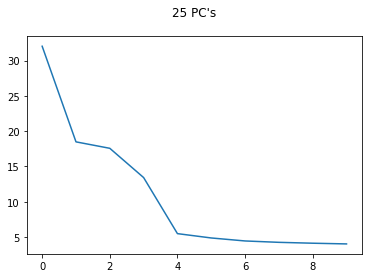

In [28]:
#Apply PCA TO Reduce the dimensions


#best setting: pc = 10, t = 150, knn=20


ndim=10
pca = PCA(n_components=ndim) 
pca.fit(iX)
trainX = iX @ pca.components_.T

plt.figure()
plt.title("25 PC's")
plt.plot(pca.explained_variance_)

In [37]:
#Evaluate Ground Truth with MDS


phate_op = phate.PHATE(random_state=42, verbose=False, knn=15).fit(trainX)#.detach().cpu().numpy())
#Accepted knn parameter was 10
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()


gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )
mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_PBMC = mds_operator.fit_transform(gtdist.detach().cpu().numpy())


In [38]:
#distind = np.argsort(np.linalg.norm((predemb - predemb.mean(0)),axis=1))

Text(0, 0.5, 'PHATE axis 2')

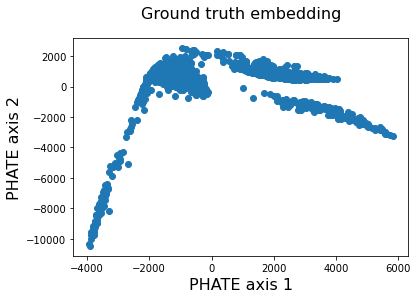

In [39]:

plt.figure()
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(phateJSDemb_PBMC[:,0],phateJSDemb_PBMC[:,1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)
#plt.xlim(-40,40)
#plt.ylim(-50,0)


In [40]:
np.save("saved_data/1500_JSDmds_phate_5_22.npy",phateJSDemb_PBMC)

In [41]:
phate_op = phate.PHATE(random_state=42, verbose=False, knn=3,t=80).fit(trainX)#.detach().cpu().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()


gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )

mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_PBMC_two = mds_operator.fit_transform(gtdist.detach().cpu().numpy())

Text(0, 0.5, 'PHATE axis 2')

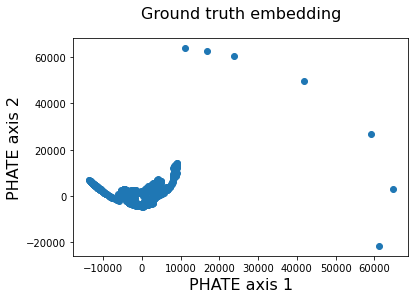

In [42]:
plt.figure()
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(phateJSDemb_PBMC_two[:,0],phateJSDemb_PBMC_two[:,1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)
#plt.xlim(-1100,1100)
#plt.ylim(-2000,1000)


In [ ]:
np.save("saved_data/1500_pbmc_1_24_JSD_phate_two.npy",phateJSDemb_PBMC_two)

In [ ]:
pbmc_data, pbmc_emb = make_pbmc(n_obs=trainX.shape[0],emb_dim=2,knn=10,indx=traind)

In [ ]:
plt.figure()
plt.title("PHATE embedding of PBMC data")
plt.scatter(pbmc_emb[:,0],pbmc_emb[:,1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

In [ ]:
print(n_dim)

In [43]:
# Data Parameters
dataset = "pbmc"
n_obs = trainX.shape[0]
n_dim = ndim
batch_size = 150

# Model param
encoder_layer = [100,100,50]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "pbmc_phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 5 # PHATE kernel number of Nearest Neighbors.
logp=False

# Trainer param
max_epochs = 150
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "pbmc_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [44]:
print(len(traind))
print(n_dim)
print(X[traind,:])

1300
10
[[-0.3383804  -0.32177243 -0.057427   ... -0.1988616  -0.21508078
  -0.52626604]
 [-0.44706267 -0.41125652 -0.06856301 ... -0.37458265 -0.29821232
   0.6696272 ]
 [-0.05464481 -0.26248235 -0.03983331 ... -0.04600471 -0.21794797
  -0.5431493 ]
 ...
 [-0.3243782  -0.26788673 -0.05320315 ... -0.10189669 -0.1509403
   1.6932458 ]
 [ 0.03041393 -0.2509491  -0.03497    ... -0.01113216 -0.2266799
  -0.55333513]
 [-0.08505407 -0.24261366 -0.03999216 ... -0.01637224 -0.18456222
  -0.5198071 ]]


In [45]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="pbmc_autoenocder_logp", name=exp_name) if wandb else False

In [46]:
PATH = os.getcwd()
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn,PATH,indx=traind)

In [47]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
#train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn,PATH)

# Defining the pytorch lightning model.
model_pbmc = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model_pbmc, train_dataloaders=train_loader)

Global seed set to 752


[Linear(in_features=10, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 16.2 K
1 | decoder | Sequential | 242   
---------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [48]:
#save model (and load model)

torch.save(model_pbmc.state_dict(),'saved_models/pbmc_model_1_25.pt')
#model.load_state_dict(torch.load('saved_models/pbmc_model_1_18.pt'))

# Beginning of Junk

In [ ]:

#model_pbmc = LitAutoencoder(input_dim=n_dim,emb_dim=emb_dim)
#model_pbmc.load_state_dict(torch.load('/home/of56/FIM_farnam/notebooks/saved_models/pbmc_model_1_17_retry.pt'))

testind = list( set(list(np.arange(X.shape[0]))) - set(traind))
pbmc_data, pbmc_phate = make_pbmc(n_obs=len(testind),emb_dim=2,knn=knn,indx=testind)

pbmc_data = pbmc_data.to('cuda')
model_pbmc.cuda()
model_pbmc.eval()
pred = model_pbmc.encode(pbmc_data).detach().cpu().numpy()

#mds_operator = MDS()
#predemb = mds_operator.fit_transform(pred)
#print(predemb.shape)

In [ ]:


phate_op = phate.PHATE(random_state=42, verbose=False, knn=knn,t=50).fit(pbmc_data.detach().cpu().numpy())#.detach().cpu().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()


gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )

mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_PBMC = mds_operator.fit_transform(gtdist.detach().cpu().numpy())


# End of Junk

In [49]:
#Getting predictions


testind = list( set(list(np.arange(X.shape[0]))) - set(traind))
pbmc_data, pbmc_phate = make_pbmc(n_obs=len(testind),emb_dim=2,knn=knn,indx=testind)

pbmc_data = pbmc_data.to('cuda')
model_pbmc.cuda()
model_pbmc.eval()
pred = model_pbmc.encode(pbmc_data).detach().cpu().numpy()

print(pred.shape)

#mds_operator = MDS()
#predemb = mds_operator.fit_transform(pred)

#print(predemb.shape)


#Performing ground JSD MDS
#phate_op = phate.PHATE(random_state=42, verbose=False, knn=10,t=50).fit(pbmc_data.detach().cpu().numpy())#.detach().cpu().numpy())
#diff_pot =torch.tensor(phate_op.diff_potential).float()
#diff_op = torch.tensor(phate_op.diff_op).float()
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )
#mds_operator = MDS(dissimilarity='precomputed')
#phateJSDemb_PBMC = mds_operator.fit_transform(gtdist.detach().cpu().numpy())



(1338, 50)


NameError: name 'predemb' is not defined

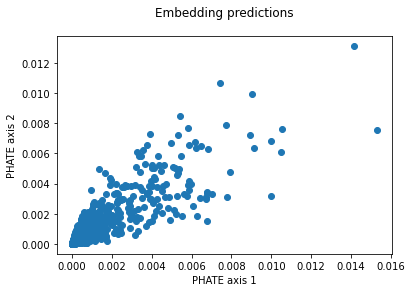

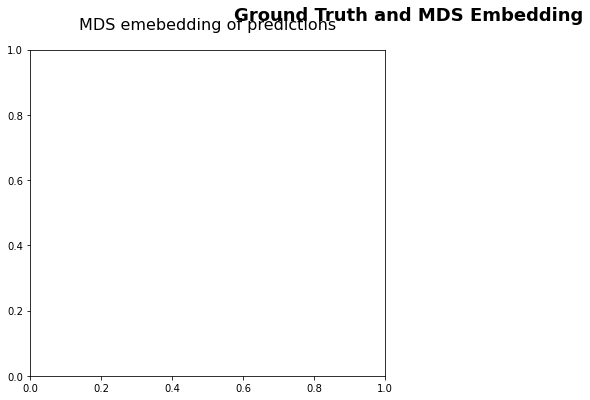

In [50]:

plt.figure()
plt.title("Embedding predictions")
plt.scatter(pred[:, 0], pred[:, 1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure(figsize = (14,6))
plt.suptitle("Ground Truth and MDS Embedding",fontweight='bold',fontsize=18)
plt.subplot(121)
plt.title("MDS emebedding of predictions",fontsize=16)
plt.scatter(predemb[:, 0], predemb[:, 1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)

plt.subplot(122)
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(pbmc_phate[:,0],pbmc_phate[:,1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)


np.save("saved_data/1500_pbmc_1_21_1500_pred.npy",pred)
np.save("saved_data/1500_pbmc_1_21_1500_pred_MDS.npy",predemb)
np.save("saved_data/1500_pbmc_1_21_1500_ground_truth.npy",pbmc_phate)
plt.savefig("Figures/1500_pbmc_1_21_1500_ground_truth.png")

In [51]:

#Compute FIM 
n_obs = len(testind)
model_pbmc.cuda()
fcn = model_pbmc.encode
fisher = FIM(pbmc_data,fcn,n_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()
e,v = fisher.get_eigs()

#quad = fisher.get_quadform(e[0,:])
#eone = np.zeros((v.shape[2])) #dimensionality of eigenvectors
#eone[0] = 1
#quad = fisher.get_quadform(eone)
volume = fisher.get_volume()

#Projecting eigenvectors to two dimensions for visualization
#tvec = torch.unsqueeze(torch.tensor(v[:,:,0]).float().cuda(),0)
#model_pbmc.eval()
#vout = model_pbmc.encode(tvec).squeeze()
#neivec = mds_operator.fit_transform(vout.detach().cpu().numpy())


/gpfs/ysm/home/of56/FIM_farnam/notebooks/../src/fim_noemb.py:113: ComplexWarning: Casting complex values to real discards the imaginary part
  FIMeigvec[i,:,:] = eigvec
/gpfs/ysm/home/of56/FIM_farnam/notebooks/../src/fim_noemb.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  FIMeigval[i,:] = eigval


In [52]:
print(len(volume))
print(volume)

1338
[4.64486196e-20 7.77081313e-17 9.71153285e-27 ... 8.85321160e-17
 2.13677164e-27 4.24988049e-31]


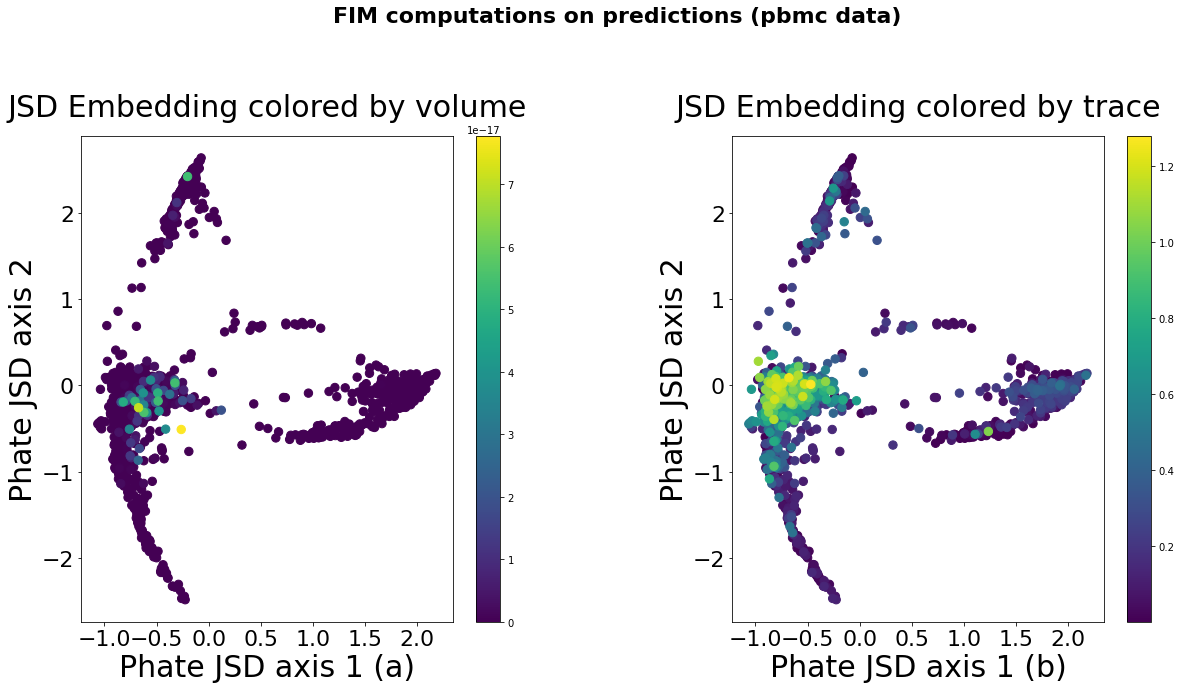

In [64]:
#Function for discarding outliers
per = 0.95 #CI to keep
def discard_out(metric,n_obs,per):
    
    ns_obs = per*n_obs
    out = int((n_obs - ns_obs)/2)
    sor = np.argsort(metric)
    lwindx = out
    upindx = n_obs - out
    sortind = sor[lwindx:upindx]
    return sortind


#Get Volume
#volume = volume/np.max(volume) #normalization
vind = discard_out(volume,n_obs,per)
nvolume = volume[vind]#/np.max(volume[vind])


#Compute quadratic form of first eigenvector
#quad = quad/np.max(quad)
#qind = discard_out(quad,n_obs,per)
#nquad = quad[qind]/np.max(quad[qind])


#Get Max eigenvalue
#emax = e[:,0]/np.max(trace) #normalized trace
#eind = discard_out(emax,n_obs,per)
#ne = emax[eind]/np.max(emax[eind])

#Get Trace
trace = np.zeros((n_obs))
for i in range(n_obs):
    trace[i] = np.sum(e[i,:])

#trace = trace/np.max(trace) #normalized trace
tind = discard_out(trace,n_obs,per)
ntrace = trace[tind]#/np.max(trace[tind])


#plt.figure(figsize=(14,10))
#plt.suptitle("FIM computations on predictions (pbmc data) ",fontsize=22,fontweight='bold')
#plt.subplots_adjust(hspace=0.4,wspace=0.4)

fig = plt.figure(figsize=(20,10))
plt.suptitle("FIM computations on predictions (pbmc data) ",fontsize=22,fontweight='bold')
plt.subplots_adjust(hspace=1.0,wspace=0.4,top=0.8)


#Trace
#plt.subplot(221)
#plt.title("Trace of FIM",fontsize=16)
#plt.plot(nvolume,linewidth=3)
#plt.xlabel("Data points",fontsize=16)
#plt.ylabel("Magnitude",fontsize=16)

#Volume
plt.subplot(121)
plt.title("JSD Embedding colored by volume",fontsize=30)
plt.scatter(pbmc_phate[vind, 0], pbmc_phate[vind, 1], c= nvolume,s=70)
plt.xlabel("Phate JSD axis 1 (a)",fontsize=30)
plt.ylabel("Phate JSD axis 2",fontsize=30)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.colorbar()

"""
#Eigenspectrum
rint = np.random.randint(0,len(testind),size=10)
plt.subplot(132)
plt.title("FIM eigenspectrum of 10 random points",fontsize=30)
for i in rint:
    plt.plot(e[i,:10],linewidth=3)
    #plt.plot(e[eind[i],:]/np.max(e[eind[i],:]))
plt.xlabel("Eigenvalues",fontsize=16)
plt.ylabel("Magnitdue",fontsize=16)
"""

#Trace
plt.subplot(122)
plt.title("JSD Embedding colored by trace",fontsize=30)
plt.scatter(pbmc_phate[tind, 0], pbmc_phate[tind, 1], c= ntrace,s=70)
plt.xlabel("Phate JSD axis 1 (b)",fontsize=30)
plt.ylabel("Phate JSD axis 2",fontsize=30)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.colorbar()




#Visualization of eignevectors
#reint = np.random.randint(0,pbmc_phate.shape[0],size=500) #Random 
#plt.subplot(224)
#plt.title("Top eigenvector of FIMs on embedding",fontsize=16)
#plt.scatter(predemb[reint,0],predemb[reint,1])
#plt.quiver(predemb[reint,0],predemb[reint,1],neivec[reint,0],neivec[reint,1],color = 'black',scale=30)
#plt.xlabel("PHATE axis 1",fontsize=16)
#plt.ylabel("PHATE axis 2",fontsize=16)
plt.savefig("Figures/pbmc_FIMcomps_1_25_JSD_MDS.png")
np.save("saved_data/pbmc_1_25_1500_ground_truth_JSD.npy",pbmc_phate)
np.save("saved_data/pbmc_1_25_ind.npy",tind)
np.save("saved_data/pbmc_1_25_1500_trace.npy",ntrace)
np.save("saved_data/pbmc_1_25_1500_volume.npy",nvolume)

# IPSC Data

In [3]:
#load data
initdir = os.getcwd()
os.chdir(os.path.abspath('..') + '/src/data')
X = sio.loadmat('ipscData.mat')['data']
os.chdir(initdir)

In [4]:
print(X.shape)

(220450, 33)


In [5]:
#Get ipsc embedding
n_obs=1500
traind = random.sample(range(0,X.shape[0]),n_obs)
ipsc_data, ipsc_emb = make_ipsc(n_obs=n_obs,emb_dim=2,knn=5,indx=traind)




In [6]:
print(ipsc_data.shape)

torch.Size([1500, 33])


In [7]:

#Ground truth embedding with subset of IPSC data
phate_op = phate.PHATE(random_state=42, verbose=False, knn=10,t=270).fit(ipsc_data.detach().cpu().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()


gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )

mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_IPSC = mds_operator.fit_transform(gtdist.detach().cpu().numpy())

In [70]:
np.save("saved_data/phateJSDemb_IPSC.npy",phateJSDemb_IPSC)

Text(0, 0.5, 'PHATE axis 2')

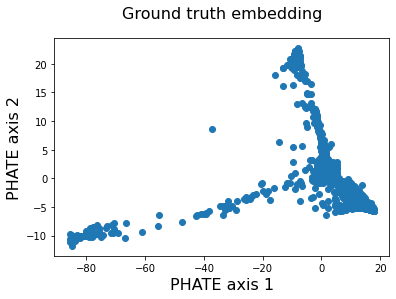

In [71]:

plt.figure()
plt.title("Ground truth embedding",fontsize=16)
plt.scatter(phateJSDemb_IPSC[:,0],phateJSDemb_IPSC[:,1])
plt.xlabel("PHATE axis 1",fontsize=16)
plt.ylabel("PHATE axis 2",fontsize=16)
#plt.xlim(-1100,1100)
#plt.ylim(-2000,1000)


Text(0, 0.5, 'PHATE axis 2')

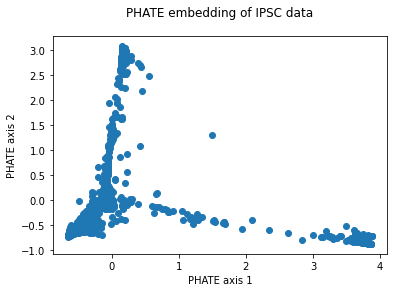

In [72]:
#IPSC data
plt.figure()
plt.title("PHATE embedding of IPSC data")
plt.scatter(ipsc_emb[:,0],ipsc_emb[:,1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

In [86]:
# Data Parameters
dataset = "ipsc"
n_obs = n_obs
n_dim = X.shape[1]
batch_size = 150

# Model param
encoder_layer = [100,100,50]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.00001
kernel_type = "ipsc_phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 10 # PHATE kernel number of Nearest Neighbors.
logp=False

# Trainer param
max_epochs = 150
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "ipsc_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [87]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="ipsc_autoenocder_logp", name=exp_name) if wandb else False

In [88]:
PATH = os.getcwd()
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn,PATH,indx=traind)

In [76]:
print(len(traind))

1500


In [89]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
#train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn,PATH)

# Defining the pytorch lightning model.
model_ipsc = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model_ipsc, train_dataloaders=train_loader)

Global seed set to 476


[Linear(in_features=33, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 18.6 K
1 | decoder | Sequential | 242   
---------------------------------------
18.8 K    Trainable params
0         Non-trainable params
18.8 K    Total params
0.075     Total estimated model params size (MB)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [90]:
#save model (and load model)

torch.save(model_ipsc.state_dict(),'saved_models/ipsc_model_1_25_night.pt')
#model.load_state_dict(torch.load('saved_models/ipsc_model_1_18.pt'))

In [91]:
print(len(traind))

1500


In [92]:

#Getting predictions

n_obs=1500
nontrain = list( set(list(np.arange(X.shape[0]))) - set(traind))
testind = random.sample(nontrain,n_obs)
ipsc_data, ipsc_phate = make_ipsc(n_obs=n_obs,emb_dim=2,knn=5,indx=testind)

print(ipsc_data.shape)

ipsc_data = ipsc_data.to('cuda')
model_ipsc.cuda()
model_ipsc.eval()
pred = model_ipsc.encode(ipsc_data).detach().cpu().numpy()

print(pred.shape)

#mds_operator = MDS()
#predemb = mds_operator.fit_transform(pred)
#print(predemb.shape)
#Performing ground JSD MDS

phate_op = phate.PHATE(random_state=42, verbose=False, knn=10,t=270).fit(ipsc_data.detach().cpu().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()
diff_op = torch.tensor(phate_op.diff_op).float()
gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
#gtdist = torch.sqrt( torch.abs(computeJSD(diff_op + 1e-7)) )
mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_IPSC = mds_operator.fit_transform(gtdist.detach().cpu().numpy())




torch.Size([1500, 33])
(1500, 50)


In [93]:
#Getting predictiosn

n_obs=1500
nontrain = list( set(list(np.arange(X.shape[0]))) - set(traind))
testind = random.sample(nontrain,n_obs)
ipsc_data, ipsc_phate = make_ipsc(n_obs=n_obs,emb_dim=2,knn=5,indx=testind)

ipsc_data = ipsc_data.to('cuda')
model_ipsc.cuda()
model_ipsc.eval()
pred = model_ipsc.encode(ipsc_data).detach().cpu().numpy()

NameError: name 'predemb' is not defined

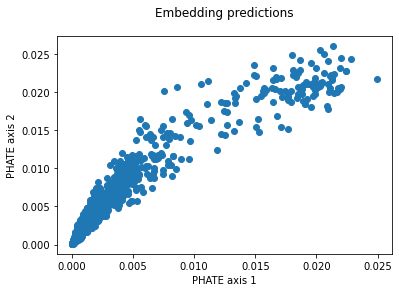

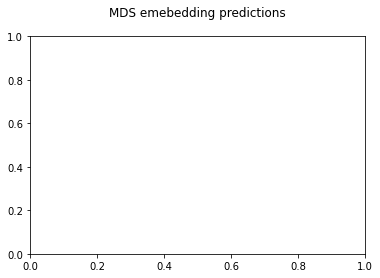

In [94]:

plt.figure()
plt.title("Embedding predictions")
plt.scatter(pred[:, 0], pred[:, 1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure()
plt.title("MDS emebedding predictions")
plt.scatter(predemb[:, 0], predemb[:, 1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")

plt.figure()
plt.title("Ground Truth embedding")
plt.scatter(ipsc_phate[:,0],ipsc_phate[:,1])
plt.xlabel("PHATE axis 1")
plt.ylabel("PHATE axis 2")



np.save("saved_data/1500_ipsc_1_21_1500_pred.npy",pred)
np.save("saved_data/1500_ipsc_1_21_1500_pred_MDS.npy",predemb)
np.save("saved_data/1500_ipsc_1_21_1500_ground_truth.npy",ipsc_phate)
plt.savefig("Figures/1500_ipsc_1_21_1500_ground_truth.png")

In [95]:

#Compute FIM 
model_ipsc.cuda()
fcn = model_ipsc.encode
fisher = FIM(ipsc_data,fcn,n_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()
e,v = fisher.get_eigs()

#quad = fisher.get_quadform(e[0,:])
#eone = np.zeros((v.shape[2])) #dimensionality of eigenvectors
#eone[0] = 1
#quad = fisher.get_quadform(eone)
volume = fisher.get_volume()

#Projecting eigenvectors to two dimensions for visualization
#tvec = torch.unsqueeze(torch.tensor(v[:,:,0]).float().cuda(),0)
#model_ipsc.eval()
#vout = model_ipsc.encode(tvec).squeeze()
#neivec = mds_operator.fit_transform(vout.detach().cpu().numpy())


In [96]:
print(volume)

[3.47808555e-122 2.62877305e-131 1.08865252e-105 ... 5.14032925e-117
 9.31064253e-090 1.13814459e-100]


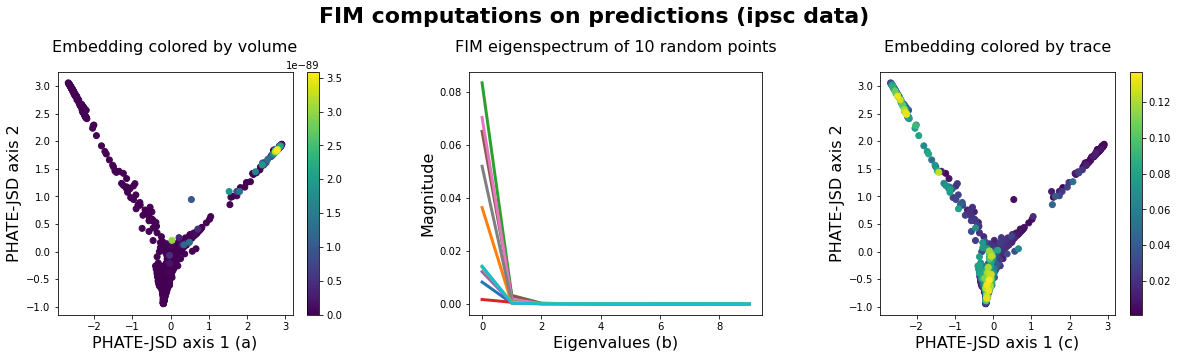

In [97]:
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 


#Function for discarding outliers
per = 0.95 #CI to keep
def discard_out(metric,n_obs,per):
    
    ns_obs = per*n_obs
    out = int((n_obs - ns_obs)/2)
    sor = np.argsort(metric)
    lwindx = out
    upindx = n_obs - out
    sortind = sor[lwindx:upindx]
    return sortind


#Get Volume
#volume = volume/np.max(volume) #normalization
vind = discard_out(volume,n_obs,per)
nvolume = volume[vind]#/np.max(volume[vind])


#Compute quadratic form of first eigenvector
#quad = quad/np.max(quad)
#qind = discard_out(quad,n_obs,per)
#nquad = quad[qind]/np.max(quad[qind])


#Get Max eigenvalue
#emax = e[:,0]/np.max(trace) #normalized trace
#eind = discard_out(emax,n_obs,per)
#ne = emax[eind]/np.max(emax[eind])


#Get Trace
trace = np.zeros((n_obs))
for i in range(n_obs):
    trace[i] = np.sum(e[i,:])

#trace = trace/np.max(trace) #normalized trace
tind = discard_out(trace,n_obs,per)
ntrace = trace[tind]#/np.max(trace[tind])


#plt.figure(figsize=(14,10))
#plt.suptitle("FIM computations on predictions (ipsc data) ",fontsize=22,fontweight='bold')
#plt.subplots_adjust(hspace=0.4,wspace=0.4)

plt.figure(figsize=(20,5))
plt.suptitle("FIM computations on predictions (ipsc data) ",fontsize=22,fontweight='bold')
plt.subplots_adjust(hspace=1.0,wspace=0.4,top=0.8)

#Trace
#plt.subplot(221)
#plt.title("Trace of FIM",fontsize=16)
#plt.plot(nvolume,linewidth=3)
#plt.xlabel("Data points",fontsize=16)
#plt.ylabel("Magnitude",fontsize=16)

#Volume
plt.subplot(131)
plt.title("Embedding colored by volume",fontsize=16)
plt.scatter(ipsc_phate[vind, 0], ipsc_phate[vind, 1], c= nvolume)
plt.xlabel("PHATE-JSD axis 1 (a)",fontsize=16)
plt.ylabel("PHATE-JSD axis 2",fontsize=16)
plt.colorbar()


#Eigenspectrum
rint = np.random.randint(0,len(testind),size=10)
plt.subplot(132)
plt.title("FIM eigenspectrum of 10 random points",fontsize=16)
for i in rint:
    plt.plot(e[i,:10],linewidth=3)
    #plt.plot(e[eind[i],:]/np.max(e[eind[i],:]))
plt.xlabel("Eigenvalues (b)",fontsize=16)
plt.ylabel("Magnitude",fontsize=16)


#Trace
plt.subplot(133)
plt.title("Embedding colored by trace",fontsize=16)
plt.scatter(ipsc_phate[tind, 0], ipsc_phate[tind, 1], c= ntrace)
plt.xlabel("PHATE-JSD axis 1 (c)",fontsize=16)
plt.ylabel("PHATE-JSD axis 2",fontsize=16)
plt.colorbar()



#Visualization of eignevectors
#reint = np.random.randint(0,ipsc_phate.shape[0],size=1000) #Random 
#plt.subplot(224)
#plt.title("Top eigenvector of FIMs on embedding",fontsize=16)
#plt.scatter(predemb[reint,0],predemb[reint,1])
#plt.quiver(predemb[reint,0],predemb[reint,1],neivec[reint,0],neivec[reint,1],color = 'black',scale=15)
#plt.xlabel("PHATE axis 1",fontsize=16)
#plt.ylabel("PHATE axis 2",fontsize=16)
plt.savefig("Figures/ipsc_FIMcomps_1_25.png")
np.save("saved_data/ipsc_1_25_1500_ground_truth_JSD.npy",phateJSDemb_IPSC)
np.save("saved_data/ipsc_1_25_ind.npy",tind)
np.save("saved_data/ipsc_1_25_1500_trace.npy",ntrace)
np.save("saved_data/ipsc_1_25_1500_volume.npy",nvolume)

# Plotting for final figure

In [ ]:


plt.savefig("Figures/5_300_tree_FIMcomps_1_25_JSD_MDS.png")
np.load("saved_data/8_200_tree_1_25_1500_ground_truth_JSD.npy",phateJSDemb_tree)
np.load("saved_data/8_200_tree_1_25_ind.npy",tind)
np.load("saved_data/8_200_tree_1_25_1500_trace.npy",ntrace)
np.load("saved_data/8_200_tree_1_25_1500_volume.npy",nvolume)


plt.savefig("Figures/pbmc_FIMcomps_1_25_JSD_MDS.png")
np.load("saved_data/pbmc_1_25_1500_ground_truth_JSD.npy",pbmc_phate)
np.load("saved_data/pbmc_1_25_ind.npy",tind)
np.load("saved_data/pbmc_1_25_1500_trace.npy",ntrace)
np.load("saved_data/pbmc_1_25_1500_volume.npy",nvolume)


plt.savefig("Figures/ipsc_FIMcomps_1_25.png")
np.save("saved_data/ipsc_1_25_1500_ground_truth_JSD.npy",phateJSDemb_IPSC)
np.save("saved_data/ipsc_1_25_ind.npy",tind)
np.save("saved_data/ipsc_1_25_1500_trace.npy",ntrace)
np.save("saved_data/ipsc_1_25_1500_volume.npy",nvolume)


# Swiss Roll

In [ ]:
# Data Parameters
dataset = "swiss_roll"
n_obs = 1000
n_dim = 3
batch_size = 100

# Model param
encoder_layer = [3,3,3]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 3 # PHATE kernel number of Nearest Neighbors.
logp=False

# Trainer param
max_epochs = 100
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "swiss_roll_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [ ]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="swiss_roll_autoenocder_logp", name=exp_name) if wandb else False

In [ ]:
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

In [ ]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
#train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

# Defining the pytorch lightning model.
model_swiss = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model_swiss, train_dataloaders=train_loader)

In [ ]:

#save model (and load model)

torch.save(model_swiss.state_dict(),'saved_models/swiss_model.pt')
#model.load_state_dict(torch.load('saved_models/sphere_model_1_18.pt'))

In [ ]:
swiss_data, swiss_phate = make_swiss(n_obs=n_obs,emb_dim=2,knn=knn)
swiss_data = swiss_data.to('cuda')
model_swiss.cuda()
model_swiss.eval()
pred = model_swiss.encode(swiss_data).detach().cpu().numpy()




In [ ]:
#Compute FIM 
n_obs = swiss_data.shape[0]
model_swiss.cuda()
fcn = model_swiss.encode
fisher = FIM(swiss_data,fcn,n_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()
e,v = fisher.get_eigs()

#quad = fisher.get_quadform(e[0,:])
#eone = np.zeros((v.shape[2])) #dimensionality of eigenvectors
#eone[0] = 1
#quad = fisher.get_quadform(eone)
volume = fisher.get_volume()

#Projecting eigenvectors to two dimensions for visualization
#tvec = torch.unsqueeze(torch.tensor(v[:,:,0]).float().cuda(),0)
#model_sphere.eval()
#vout = model_swiss.encode(tvec).squeeze()
#neivec = mds_operator.fit_transform(vout.detach().cpu().numpy())